In [33]:
import pandas as pd
import torch
import re
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load Dataset from Colab File Manager
from google.colab import files

uploaded = files.upload()  # Opens a file upload dialog
file_path = list(uploaded.keys())[0]  # Get uploaded file name
df = pd.read_csv(file_path)

# Text Cleaning Function
def clean_text(text):
    text = str(text).lower()  # Handle NaN as string
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_resume'] = df['Resume'].apply(clean_text)

# Encode Job Roles (Target)
label_encoder = LabelEncoder()
df['encoded_category'] = label_encoder.fit_transform(df['Category'])

# Tokenizer Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, max_len=512):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Tokenizing Data
tokenized_data = tokenize_data(df['cleaned_resume'].tolist(), max_len=512)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    tokenized_data['input_ids'],
    df['encoded_category'].values,
    test_size=0.2,
    random_state=42
)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


Saving resume.csv to resume (2).csv


<ipython-input-33-43f3b8e5a389>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long))
<ipython-input-33-43f3b8e5a389>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))


In [35]:
import torch.nn as nn
from transformers import BertModel

class ResumeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResumeClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.fc(self.dropout(cls_output))

# Initialize Model
model = ResumeClassifier(num_classes=len(df['encoded_category'].unique()))

# GPU Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResumeClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [36]:
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim

# Optimizer & Loss Function
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

# Mixed Precision for Memory Optimization
scaler = GradScaler()

# Training Loop
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():  # Mixed Precision
                outputs = model(input_ids, attention_mask=(input_ids != 0).int())
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')

# Start Training
train(model, train_loader, criterion, optimizer, epochs=5)


<ipython-input-36-ee88f5fff9e0>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-36-ee88f5fff9e0>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


Epoch 1, Loss: 2.9238117650612114
Epoch 2, Loss: 1.7084632165653189
Epoch 3, Loss: 0.7329733937057024
Epoch 4, Loss: 0.30712528818661405
Epoch 5, Loss: 0.15157424297529398


In [46]:
epochs=5
total_steps = len(train_loader) * epochs


In [48]:
from transformers import AdamW, get_scheduler
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=total_steps
)

# Training Loop
for epoch in range(5):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader):
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        with autocast():  # Mixed precision
            outputs = model(input_ids, attention_mask=(input_ids != 0).int())
            loss = criterion(outputs, labels) / 4  # Gradient accumulation steps

        scaler.scale(loss).backward()

        if (step + 1) % 4 == 0:  # Perform optimizer step after accumulation
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')


<ipython-input-48-92b3100af462>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-48-92b3100af462>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Epoch 1, Loss: 0.0249
Epoch 2, Loss: 0.0243
Epoch 3, Loss: 0.0231
Epoch 4, Loss: 0.0212
Epoch 5, Loss: 0.0190


In [49]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluation Function
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=(input_ids != 0).int())
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Evaluate the Model
evaluate(model, test_loader)


Accuracy: 1.0
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      1.00      1.00        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
                   Hadoop       1.00      1.00 

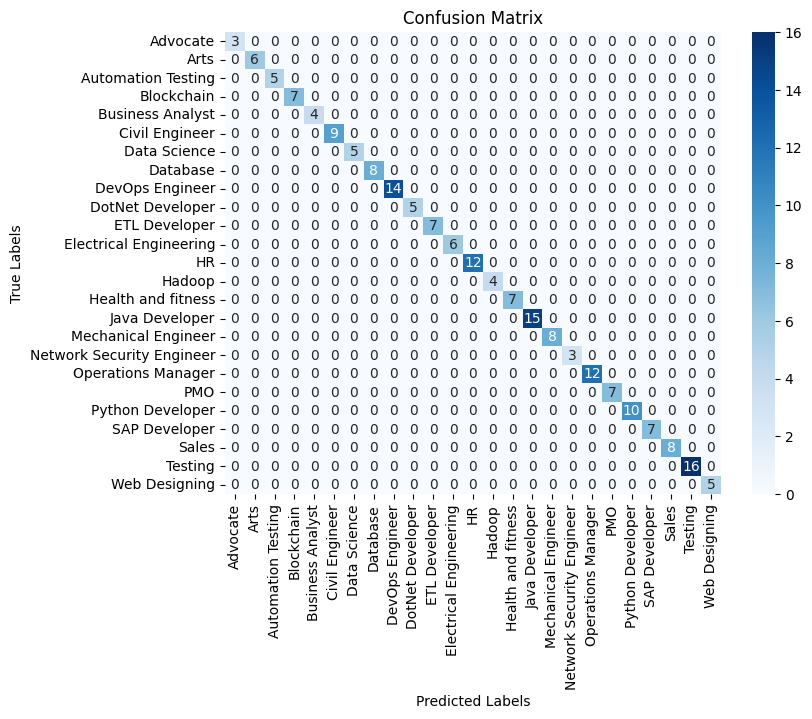

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)
import torch


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Predictions for Test Data
def get_predictions(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=(input_ids != 0).int())
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_predictions(model, test_loader)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


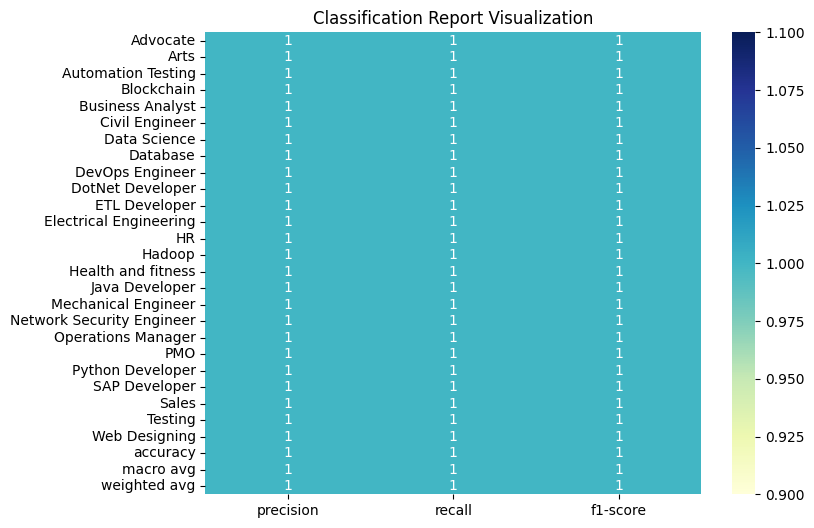

In [58]:
from sklearn.metrics import classification_report

# Generate Report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='YlGnBu')
plt.title('Classification Report Visualization')
plt.show()


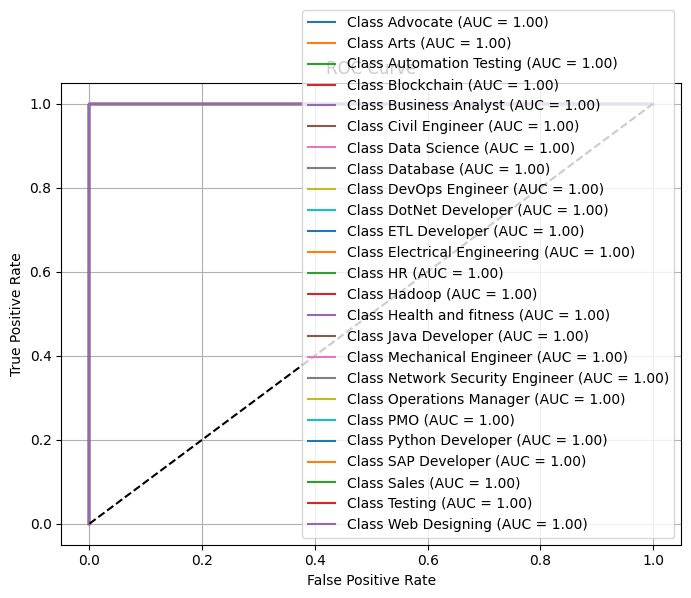

In [59]:
# Collect logits instead of predicted labels
def get_logits(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=(input_ids != 0).int())

            all_logits.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_logits), np.array(all_labels)

# Collect logits and labels
y_logits, y_true = get_logits(model, test_loader)

# Apply Softmax to logits for probabilities
y_pred_proba = torch.softmax(torch.tensor(y_logits), dim=1).cpu().numpy()

# Binarize true labels for ROC curve
y_true_bin = label_binarize(y_true, classes=np.arange(len(label_encoder.classes_)))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [57]:
def predict_resume(text, model, tokenizer, label_encoder, max_len=512):
    model.eval()

    # Improved Text Cleaning
    cleaned_text = clean_text(text)

    # Enhanced Tokenization
    tokenized_text = tokenizer(
        cleaned_text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = tokenized_text['input_ids'].to(device)
    attention_mask = tokenized_text['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    predicted_role = label_encoder.inverse_transform([predicted_class])[0]
    confidence = probabilities[0, predicted_class].item()  # Add confidence score

    return predicted_role, confidence

sample_resume = """
Human Resources professional with 5+ years of experience in employee relations, recruitment, and performance management.
Skilled in managing end-to-end recruitment processes, conducting interviews, and onboarding new hires.
Proficient in HR software such as SAP SuccessFactors, Workday, and BambooHR.
Experienced in handling employee grievances, ensuring compliance with labor laws, and developing employee engagement strategies.
Strong expertise in payroll management, benefits administration, and training program development.
Proven track record of implementing policies that improved employee retention and enhanced workplace culture.
"""



# Test the Improved Prediction
predicted_role, confidence = predict_resume(sample_resume, model, tokenizer, label_encoder)
print(f"Predicted Role: {predicted_role} (Confidence: {confidence:.2%})")


Predicted Role: HR (Confidence: 93.04%)


In [60]:
# Save Model
model_save_path = '/content/bert_resume_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {model_save_path}')


Model saved at /content/bert_resume_model.pth
